**Installing the packages and dependancies for the project**
#----------------------------------------------------------

In [ ]:
!pip install torch torch-geometric
!pip install dowhy
!pip install networkx

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 49.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 383.4/383.4 kB 19.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 174.5/174.5 kB 11.7 MB/s eta 0:00:00


Importing the required libraries and packages

In [ ]:
import numpy as np
import pandas as pd
import networkx as nx
from dowhy import CausalModel
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
import matplotlib.pyplot as plt
from torch_geometric.data import Data
from sklearn.model_selection import train_test_split

**Load and preprocess the Breast Cancer dataset**
# -------------------------------------------
 In this step, we load the Breast Cancer dataset we downloaded from kaggle.This dataset is used for classifying if a tumor is classified as malignant or benign.This dataset is chosen as medical field is always intrested in understanding the effect of each feature on the final outcome and will benefit from this analysis.

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
dataset = pd.read_csv('/content/ADAdata.csv')

# Drop the 30th column (index 30) and the 'Unnamed: 32' column
dataset = dataset.drop(columns=[dataset.columns[30], 'Unnamed: 32'])

Convert features and labels to DataFrame for causal analysis.


In [ ]:
# Extract features and labels
labels = dataset['diagnosis'].map({'M': 1, 'B': 0})
features = dataset.drop(columns=['diagnosis', 'id']).values  # Dropping 'diagnosis' and 'id' columns

# Now you have the full dataset with 'diagnosis' encoded as 1 and 0


In [ ]:
#Converting it to the format required for training the model
features = torch.tensor(features, dtype=torch.float).to(device)
labels = torch.tensor(labels, dtype=torch.long).to(device)

# Handle NaN or Inf values
if torch.any(torch.isnan(features)) or torch.any(torch.isinf(features)):
    print("NaN or Inf detected in the input data!")

    # Option 1: Replace NaNs with the mean of each column
    features = features.cpu().numpy()
    nan_mask = np.isnan(features)

    for col in range(features.shape[1]):
        features[nan_mask[:, col], col] = np.nanmean(features[:, col])

    # Convert back to tensor
    features = torch.tensor(features, dtype=torch.float).to(device)

# Ensure labels are not empty after cleaning
if features.size(0) == 0 or labels.size(0) == 0:
    raise ValueError("No valid data left after cleaning!")


Split the data into train and test data for testing the models performance.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(features.cpu().numpy(), labels.cpu().numpy(), test_size=0.2, random_state=42)

# Convert the splits back to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float).to(device)
y_train = torch.tensor(y_train, dtype=torch.long).to(device)
X_test = torch.tensor(X_test, dtype=torch.float).to(device)
y_test = torch.tensor(y_test, dtype=torch.long).to(device)

**GCN Model**
# ---------------------------
 We define a Graph Convolutional Network (GCN) model using two GCN layers.
 The first layer transforms the input features into 16-dimensional representations,and the second layer produces class predictions. The model also uses dropout for regularization.
 We have chosen a very simple architecture for GNN this can definetely modified based on the complexity of the dataset to improve the model's performance.

In [ ]:
class GNNModel(torch.nn.Module):
    def __init__(self):
        super(GNNModel, self).__init__()
        self.conv1 = GCNConv(X_train.size(1), 16)  # Input dimension is number of features
        self.conv2 = GCNConv(16, 2)  # Binary classification: 2 classes

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)



Create the edge indexes for the test and train graphs

In [ ]:
# Generate edge indices for train and test graphs based on the number of nodes in each split
def create_edge_index(num_nodes):
    """
    Creates a fully connected edge index for a graph with 'num_nodes'.
    """
    node_indices = torch.arange(num_nodes).to(device)
    edges = torch.combinations(node_indices, r=2).t().contiguous()
    return edges.to(device)

# Train and test edge indices
train_edge_index = create_edge_index(len(X_train))
test_edge_index = create_edge_index(len(X_test))


Initialise the model

In [ ]:
# Create train and test data objects
train_data = Data(x=X_train, edge_index=train_edge_index, y=y_train)
test_data = Data(x=X_test, edge_index=test_edge_index, y=y_test)

# Initialize model, optimizer, and loss function
model = GNNModel().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()

Train the GCN model : In this function, we perform the training of the GCN model by computing the loss and backpropagating the gradients.

In [ ]:
def train():
    model.train()
    optimizer.zero_grad()
    out = model(train_data.x, train_data.edge_index)
    loss = criterion(out, train_data.y)
    loss.backward()
    optimizer.step()
    return loss.item()

 Evaluate the GCN model : This function evaluates the accuracy of the trained model on the test set.

In [ ]:
def test(data_obj):
    model.eval()
    with torch.no_grad():
        out = model(data_obj.x, data_obj.edge_index)
    pred = out.argmax(dim=1)
    acc = (pred == data_obj.y).sum().item() / data_obj.y.size(0)
    return acc

Finetuning function:Since the test and train graphs are seperate graphs. In order to transfer the node embedding learning during the training phase onto the test graph we incorporate finetuning the test graph based on the training graph knowledge.Its essentially like loading the pre-trained graph and adapting it to the node structure of the test graph.

In [ ]:
def fine_tune_test_graph():
    test_optimizer = torch.optim.Adam(model.parameters(), lr=0.001)  # Lower learning rate for fine-tuning
    model.train()

    for epoch in range(50):  # Fine-tune for a few epochs
        test_optimizer.zero_grad()
        out = model(test_data.x, test_data.edge_index)
        loss = criterion(out, test_data.y)
        loss.backward()
        test_optimizer.step()

    print("Fine-tuning completed.")

Train the GCN model for a few epochs. Finetune it for few epochs and test the models accuracy for test dataset.

In [ ]:
num_epochs = 200
for epoch in range(num_epochs):
    loss = train()
    if epoch % 20 == 0:
        train_acc = test(train_data)
        test_acc = test(test_data)
        print(f'Epoch: {epoch}, Loss: {loss:.4f}, Train Accuracy: {train_acc:.4f}, Test Accuracy: {test_acc:.4f}')

# Step 8: Fine-tune the test graph after training
fine_tune_test_graph()

# Re-evaluate the test accuracy after fine-tuning
test_acc = test(test_data)
print(f'Final Test Accuracy after fine-tuning: {test_acc:.4f}')


Epoch: 0, Loss: 0.6772, Train Accuracy: 0.6286, Test Accuracy: 0.6228
Epoch: 20, Loss: 0.6603, Train Accuracy: 0.6286, Test Accuracy: 0.6228
Epoch: 40, Loss: 0.6602, Train Accuracy: 0.6286, Test Accuracy: 0.6228
Epoch: 60, Loss: 0.6598, Train Accuracy: 0.6286, Test Accuracy: 0.6228
Epoch: 80, Loss: 0.6599, Train Accuracy: 0.6286, Test Accuracy: 0.6228
Epoch: 100, Loss: 0.6608, Train Accuracy: 0.6286, Test Accuracy: 0.6228
Epoch: 120, Loss: 0.6597, Train Accuracy: 0.6286, Test Accuracy: 0.6228
Epoch: 140, Loss: 0.6589, Train Accuracy: 0.6286, Test Accuracy: 0.6228
Epoch: 160, Loss: 0.6602, Train Accuracy: 0.6286, Test Accuracy: 0.6228
Epoch: 180, Loss: 0.6597, Train Accuracy: 0.6286, Test Accuracy: 0.6228
Fine-tuning completed.
Final Test Accuracy after fine-tuning: 0.6228


Preparing data for causal inference/Analysis

In [ ]:
columns = [ 'radius_mean', 'texture_mean', 'perimeter_mean',
       'area_mean', 'smoothness_mean', 'compactness_mean', 'concavity_mean',
       'concave points_mean', 'symmetry_mean', 'fractal_dimension_mean',
       'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se',
       'compactness_se', 'concavity_se', 'concave points_se', 'symmetry_se',
       'fractal_dimension_se', 'radius_worst', 'texture_worst',
       'perimeter_worst', 'area_worst', 'smoothness_worst',
       'compactness_worst', 'concavity_worst', 'concave points_worst',
       'fractal_dimension_worst']

# Convert features and labels to DataFrame for causal analysis
features_df = pd.DataFrame(X_train.cpu().numpy(), columns=columns)  # Only 31 features
labels_df = pd.Series(y_train.cpu().numpy(), name='label')
full_data = pd.concat([features_df, labels_df], axis=1)

Monte Carlo Simulation with Dynamic Confounder Selection
# -----------------------------------------------------------------
 In this step, we run a Monte Carlo simulation where we randomly select a feature as the treatment (or cause), and all other features act as confounders. We dynamically build a causal graph and use DoWhy for causal inference.This is one of the most important steps as we are allowing every feature to have confounding variables and calculating the causal effect to ensure the robustness of our feature selection

In [ ]:
def monte_carlo_dynamic_confounded_feature_selection(num_simulations=100):
    causal_results = []

    for i in range(num_simulations):
        print(f"Running simulation {i + 1}/{num_simulations}")

        # Randomly select a treatment feature for this simulation
        treatment_feature = np.random.choice(features_df.columns)

        # All other features become potential confounders
        potential_confounders = [f for f in features_df.columns if f != treatment_feature]

        # Build the causal graph dynamically
        causal_graph = nx.DiGraph()

        # Add edges from the treatment feature to the outcome (label)
        causal_graph.add_edge(treatment_feature, 'label')

        # Add edges from confounders to both the treatment feature and the outcome
        for confounder in potential_confounders:
            causal_graph.add_edge(confounder, treatment_feature)  # Confounders affecting treatment
            causal_graph.add_edge(confounder, 'label')  # Confounders affecting the outcome

        # Define the causal model using DoWhy
        causal_model = CausalModel(
            data=full_data[[treatment_feature, *potential_confounders, 'label']],
            treatment=treatment_feature,  # The feature being treated as the cause
            outcome='label',
            graph=causal_graph
        )

        # Identify the causal effect
        identified_estimand = causal_model.identify_effect()

        # Estimate the causal effect adjusting for all confounders
        causal_estimate = causal_model.estimate_effect(identified_estimand, method_name="backdoor.linear_regression")
        print(f"Estimated Causal Effect for {treatment_feature}:", causal_estimate.value)

        # Store the results for analysis
        causal_results.append({
            'simulation': i,
            'feature': treatment_feature,
            'confounders': potential_confounders,
            'causal_effect': causal_estimate.value
        })

    return pd.DataFrame(causal_results)


 Run Monte Carlo feature selection : We run the Monte Carlo simulations with 100 iterations to assess the causal effect of each feature.Since the feature gets selected at random to ensure every feature gets selected we have statistiaclly calculated the number of iterations and chosen a value of 100.

In [ ]:
simulation_results = monte_carlo_dynamic_confounded_feature_selection()
summary_stats = simulation_results.groupby('feature')['causal_effect'].agg(['mean', 'std', 'count'])

# Print the summary statistics
print("Summary Statistics of Causal Effects for Each Feature:")
print(summary_stats)

Running simulation 1/100


/usr/local/lib/python3.10/dist-packages/dowhy/causal_estimators/regression_estimator.py:179: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]


Estimated Causal Effect for concavity_se: -3.9619643539526974
Running simulation 2/100


/usr/local/lib/python3.10/dist-packages/dowhy/causal_estimators/regression_estimator.py:179: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]


Estimated Causal Effect for perimeter_worst: -0.008197838155489023
Running simulation 3/100


/usr/local/lib/python3.10/dist-packages/dowhy/causal_estimators/regression_estimator.py:179: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]


Estimated Causal Effect for concave points_mean: 4.782443201582993
Running simulation 4/100


/usr/local/lib/python3.10/dist-packages/dowhy/causal_estimators/regression_estimator.py:179: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]


Estimated Causal Effect for compactness_mean: -5.269154881432373
Running simulation 5/100


/usr/local/lib/python3.10/dist-packages/dowhy/causal_estimators/regression_estimator.py:179: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]


Estimated Causal Effect for perimeter_se: -0.015970088026629747
Running simulation 6/100


/usr/local/lib/python3.10/dist-packages/dowhy/causal_estimators/regression_estimator.py:179: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]


Estimated Causal Effect for concave points_worst: -1.170191154397016
Running simulation 7/100


/usr/local/lib/python3.10/dist-packages/dowhy/causal_estimators/regression_estimator.py:179: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]


Estimated Causal Effect for concave points_mean: 4.782443201582993
Running simulation 8/100


/usr/local/lib/python3.10/dist-packages/dowhy/causal_estimators/regression_estimator.py:179: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]


Estimated Causal Effect for concave points_se: 17.231472782589023
Running simulation 9/100


/usr/local/lib/python3.10/dist-packages/dowhy/causal_estimators/regression_estimator.py:179: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]


Estimated Causal Effect for area_worst: -0.0010768756345569397
Running simulation 10/100


/usr/local/lib/python3.10/dist-packages/dowhy/causal_estimators/regression_estimator.py:179: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]


Estimated Causal Effect for area_worst: -0.0010768756345569397
Running simulation 11/100


/usr/local/lib/python3.10/dist-packages/dowhy/causal_estimators/regression_estimator.py:179: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]


Estimated Causal Effect for compactness_mean: -5.269154881432373
Running simulation 12/100


/usr/local/lib/python3.10/dist-packages/dowhy/causal_estimators/regression_estimator.py:179: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]


Estimated Causal Effect for radius_se: 0.396851739061206
Running simulation 13/100


/usr/local/lib/python3.10/dist-packages/dowhy/causal_estimators/regression_estimator.py:179: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]


Estimated Causal Effect for concave points_se: 17.231472782589023
Running simulation 14/100


/usr/local/lib/python3.10/dist-packages/dowhy/causal_estimators/regression_estimator.py:179: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]


Estimated Causal Effect for concave points_worst: -1.170191154397016
Running simulation 15/100


/usr/local/lib/python3.10/dist-packages/dowhy/causal_estimators/regression_estimator.py:179: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]


Estimated Causal Effect for texture_se: -0.040669934574764754
Running simulation 16/100


/usr/local/lib/python3.10/dist-packages/dowhy/causal_estimators/regression_estimator.py:179: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]


Estimated Causal Effect for radius_worst: 0.23391172722099496
Running simulation 17/100


/usr/local/lib/python3.10/dist-packages/dowhy/causal_estimators/regression_estimator.py:179: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]


Estimated Causal Effect for smoothness_mean: -0.908994299556281
Running simulation 18/100


/usr/local/lib/python3.10/dist-packages/dowhy/causal_estimators/regression_estimator.py:179: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]


Estimated Causal Effect for area_worst: -0.0010768756345569397
Running simulation 19/100


/usr/local/lib/python3.10/dist-packages/dowhy/causal_estimators/regression_estimator.py:179: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]


Estimated Causal Effect for area_se: -0.0009694385763006075
Running simulation 20/100


/usr/local/lib/python3.10/dist-packages/dowhy/causal_estimators/regression_estimator.py:179: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]


Estimated Causal Effect for perimeter_worst: -0.008197838155489023
Running simulation 21/100


/usr/local/lib/python3.10/dist-packages/dowhy/causal_estimators/regression_estimator.py:179: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]


Estimated Causal Effect for concavity_mean: 0.9868002385245371
Running simulation 22/100


/usr/local/lib/python3.10/dist-packages/dowhy/causal_estimators/regression_estimator.py:179: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]


Estimated Causal Effect for radius_se: 0.396851739061206
Running simulation 23/100


/usr/local/lib/python3.10/dist-packages/dowhy/causal_estimators/regression_estimator.py:179: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]


Estimated Causal Effect for compactness_se: -2.5149282530750465
Running simulation 24/100


/usr/local/lib/python3.10/dist-packages/dowhy/causal_estimators/regression_estimator.py:179: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]


Estimated Causal Effect for smoothness_se: 15.685965657660061
Running simulation 25/100


/usr/local/lib/python3.10/dist-packages/dowhy/causal_estimators/regression_estimator.py:179: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]


Estimated Causal Effect for perimeter_worst: -0.008197838155489023
Running simulation 26/100


/usr/local/lib/python3.10/dist-packages/dowhy/causal_estimators/regression_estimator.py:179: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]


Estimated Causal Effect for radius_se: 0.396851739061206
Running simulation 27/100


/usr/local/lib/python3.10/dist-packages/dowhy/causal_estimators/regression_estimator.py:179: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]


Estimated Causal Effect for radius_se: 0.396851739061206
Running simulation 28/100


/usr/local/lib/python3.10/dist-packages/dowhy/causal_estimators/regression_estimator.py:179: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]


Estimated Causal Effect for symmetry_se: 3.297865634856487
Running simulation 29/100


/usr/local/lib/python3.10/dist-packages/dowhy/causal_estimators/regression_estimator.py:179: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]


Estimated Causal Effect for compactness_worst: 0.8719205517672541
Running simulation 30/100


/usr/local/lib/python3.10/dist-packages/dowhy/causal_estimators/regression_estimator.py:179: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]


Estimated Causal Effect for radius_mean: -0.23286460563950762
Running simulation 31/100


/usr/local/lib/python3.10/dist-packages/dowhy/causal_estimators/regression_estimator.py:179: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]


Estimated Causal Effect for texture_mean: -0.0014917771945219815
Running simulation 32/100


/usr/local/lib/python3.10/dist-packages/dowhy/causal_estimators/regression_estimator.py:179: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]


Estimated Causal Effect for area_worst: -0.0010768756345569397
Running simulation 33/100


/usr/local/lib/python3.10/dist-packages/dowhy/causal_estimators/regression_estimator.py:179: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]


Estimated Causal Effect for concave points_mean: 4.782443201582993
Running simulation 34/100


/usr/local/lib/python3.10/dist-packages/dowhy/causal_estimators/regression_estimator.py:179: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]


Estimated Causal Effect for texture_se: -0.040669934574764754
Running simulation 35/100


/usr/local/lib/python3.10/dist-packages/dowhy/causal_estimators/regression_estimator.py:179: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]


Estimated Causal Effect for concavity_worst: 0.5711473062321287
Running simulation 36/100


/usr/local/lib/python3.10/dist-packages/dowhy/causal_estimators/regression_estimator.py:179: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]


Estimated Causal Effect for radius_worst: 0.23391172722099496
Running simulation 37/100


/usr/local/lib/python3.10/dist-packages/dowhy/causal_estimators/regression_estimator.py:179: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]


Estimated Causal Effect for fractal_dimension_se: -5.438548504176314
Running simulation 38/100


/usr/local/lib/python3.10/dist-packages/dowhy/causal_estimators/regression_estimator.py:179: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]


Estimated Causal Effect for radius_se: 0.396851739061206
Running simulation 39/100


/usr/local/lib/python3.10/dist-packages/dowhy/causal_estimators/regression_estimator.py:179: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]


Estimated Causal Effect for concave points_mean: 4.782443201582993
Running simulation 40/100


/usr/local/lib/python3.10/dist-packages/dowhy/causal_estimators/regression_estimator.py:179: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]


Estimated Causal Effect for concave points_se: 17.231472782589023
Running simulation 41/100


/usr/local/lib/python3.10/dist-packages/dowhy/causal_estimators/regression_estimator.py:179: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]


Estimated Causal Effect for fractal_dimension_mean: 5.999570281570069
Running simulation 42/100


/usr/local/lib/python3.10/dist-packages/dowhy/causal_estimators/regression_estimator.py:179: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]


Estimated Causal Effect for compactness_se: -2.5149282530750465
Running simulation 43/100


/usr/local/lib/python3.10/dist-packages/dowhy/causal_estimators/regression_estimator.py:179: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]


Estimated Causal Effect for concave points_worst: -1.170191154397016
Running simulation 44/100


/usr/local/lib/python3.10/dist-packages/dowhy/causal_estimators/regression_estimator.py:179: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]


Estimated Causal Effect for concavity_mean: 0.9868002385245371
Running simulation 45/100


/usr/local/lib/python3.10/dist-packages/dowhy/causal_estimators/regression_estimator.py:179: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]


Estimated Causal Effect for texture_worst: 0.013917734263562891
Running simulation 46/100


/usr/local/lib/python3.10/dist-packages/dowhy/causal_estimators/regression_estimator.py:179: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]


Estimated Causal Effect for radius_mean: -0.23286460563950762
Running simulation 47/100


/usr/local/lib/python3.10/dist-packages/dowhy/causal_estimators/regression_estimator.py:179: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]


Estimated Causal Effect for symmetry_se: 3.297865634856487
Running simulation 48/100


/usr/local/lib/python3.10/dist-packages/dowhy/causal_estimators/regression_estimator.py:179: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]


Estimated Causal Effect for compactness_worst: 0.8719205517672541
Running simulation 49/100


/usr/local/lib/python3.10/dist-packages/dowhy/causal_estimators/regression_estimator.py:179: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]


Estimated Causal Effect for perimeter_worst: -0.008197838155489023
Running simulation 50/100


/usr/local/lib/python3.10/dist-packages/dowhy/causal_estimators/regression_estimator.py:179: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]


Estimated Causal Effect for concave points_se: 17.231472782589023
Running simulation 51/100


/usr/local/lib/python3.10/dist-packages/dowhy/causal_estimators/regression_estimator.py:179: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]


Estimated Causal Effect for radius_mean: -0.23286460563950762
Running simulation 52/100


/usr/local/lib/python3.10/dist-packages/dowhy/causal_estimators/regression_estimator.py:179: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]


Estimated Causal Effect for area_worst: -0.0010768756345569397
Running simulation 53/100


/usr/local/lib/python3.10/dist-packages/dowhy/causal_estimators/regression_estimator.py:179: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]


Estimated Causal Effect for texture_worst: 0.013917734263562891
Running simulation 54/100


/usr/local/lib/python3.10/dist-packages/dowhy/causal_estimators/regression_estimator.py:179: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]


Estimated Causal Effect for compactness_se: -2.5149282530750465
Running simulation 55/100


/usr/local/lib/python3.10/dist-packages/dowhy/causal_estimators/regression_estimator.py:179: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]


Estimated Causal Effect for smoothness_worst: 0.6021511983773997
Running simulation 56/100


/usr/local/lib/python3.10/dist-packages/dowhy/causal_estimators/regression_estimator.py:179: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]


Estimated Causal Effect for smoothness_se: 15.685965657660061
Running simulation 57/100


/usr/local/lib/python3.10/dist-packages/dowhy/causal_estimators/regression_estimator.py:179: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]


Estimated Causal Effect for concave points_mean: 4.782443201582993
Running simulation 58/100


/usr/local/lib/python3.10/dist-packages/dowhy/causal_estimators/regression_estimator.py:179: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]


Estimated Causal Effect for area_worst: -0.0010768756345569397
Running simulation 59/100


/usr/local/lib/python3.10/dist-packages/dowhy/causal_estimators/regression_estimator.py:179: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]


Estimated Causal Effect for perimeter_mean: 0.025242328841587724
Running simulation 60/100


/usr/local/lib/python3.10/dist-packages/dowhy/causal_estimators/regression_estimator.py:179: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]


Estimated Causal Effect for perimeter_worst: -0.008197838155489023
Running simulation 61/100


/usr/local/lib/python3.10/dist-packages/dowhy/causal_estimators/regression_estimator.py:179: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]


Estimated Causal Effect for fractal_dimension_mean: 5.999570281570069
Running simulation 62/100


/usr/local/lib/python3.10/dist-packages/dowhy/causal_estimators/regression_estimator.py:179: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]


Estimated Causal Effect for fractal_dimension_mean: 5.999570281570069
Running simulation 63/100


/usr/local/lib/python3.10/dist-packages/dowhy/causal_estimators/regression_estimator.py:179: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]


Estimated Causal Effect for concave points_mean: 4.782443201582993
Running simulation 64/100


/usr/local/lib/python3.10/dist-packages/dowhy/causal_estimators/regression_estimator.py:179: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]


Estimated Causal Effect for radius_se: 0.396851739061206
Running simulation 65/100


/usr/local/lib/python3.10/dist-packages/dowhy/causal_estimators/regression_estimator.py:179: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]


Estimated Causal Effect for compactness_worst: 0.8719205517672541
Running simulation 66/100


/usr/local/lib/python3.10/dist-packages/dowhy/causal_estimators/regression_estimator.py:179: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]


Estimated Causal Effect for perimeter_se: -0.015970088026629747
Running simulation 67/100


/usr/local/lib/python3.10/dist-packages/dowhy/causal_estimators/regression_estimator.py:179: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]


Estimated Causal Effect for fractal_dimension_se: -5.438548504176314
Running simulation 68/100


/usr/local/lib/python3.10/dist-packages/dowhy/causal_estimators/regression_estimator.py:179: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]


Estimated Causal Effect for smoothness_mean: -0.908994299556281
Running simulation 69/100


/usr/local/lib/python3.10/dist-packages/dowhy/causal_estimators/regression_estimator.py:179: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]


Estimated Causal Effect for fractal_dimension_se: -5.438548504176314
Running simulation 70/100


/usr/local/lib/python3.10/dist-packages/dowhy/causal_estimators/regression_estimator.py:179: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]


Estimated Causal Effect for perimeter_worst: -0.008197838155489023
Running simulation 71/100


/usr/local/lib/python3.10/dist-packages/dowhy/causal_estimators/regression_estimator.py:179: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]


Estimated Causal Effect for concavity_se: -3.9619643539526974
Running simulation 72/100


/usr/local/lib/python3.10/dist-packages/dowhy/causal_estimators/regression_estimator.py:179: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]


Estimated Causal Effect for perimeter_mean: 0.025242328841587724
Running simulation 73/100


/usr/local/lib/python3.10/dist-packages/dowhy/causal_estimators/regression_estimator.py:179: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]


Estimated Causal Effect for compactness_worst: 0.8719205517672541
Running simulation 74/100


/usr/local/lib/python3.10/dist-packages/dowhy/causal_estimators/regression_estimator.py:179: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]


Estimated Causal Effect for compactness_mean: -5.269154881432373
Running simulation 75/100


/usr/local/lib/python3.10/dist-packages/dowhy/causal_estimators/regression_estimator.py:179: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]


Estimated Causal Effect for radius_mean: -0.23286460563950762
Running simulation 76/100


/usr/local/lib/python3.10/dist-packages/dowhy/causal_estimators/regression_estimator.py:179: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]


Estimated Causal Effect for compactness_mean: -5.269154881432373
Running simulation 77/100


/usr/local/lib/python3.10/dist-packages/dowhy/causal_estimators/regression_estimator.py:179: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]


Estimated Causal Effect for symmetry_mean: 0.7383308503491511
Running simulation 78/100


/usr/local/lib/python3.10/dist-packages/dowhy/causal_estimators/regression_estimator.py:179: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]


Estimated Causal Effect for texture_mean: -0.0014917771945219815
Running simulation 79/100


/usr/local/lib/python3.10/dist-packages/dowhy/causal_estimators/regression_estimator.py:179: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]


Estimated Causal Effect for area_worst: -0.0010768756345569397
Running simulation 80/100


/usr/local/lib/python3.10/dist-packages/dowhy/causal_estimators/regression_estimator.py:179: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]


Estimated Causal Effect for concavity_worst: 0.5711473062321287
Running simulation 81/100


/usr/local/lib/python3.10/dist-packages/dowhy/causal_estimators/regression_estimator.py:179: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]


Estimated Causal Effect for compactness_worst: 0.8719205517672541
Running simulation 82/100


/usr/local/lib/python3.10/dist-packages/dowhy/causal_estimators/regression_estimator.py:179: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]


Estimated Causal Effect for perimeter_worst: -0.008197838155489023
Running simulation 83/100


/usr/local/lib/python3.10/dist-packages/dowhy/causal_estimators/regression_estimator.py:179: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]


Estimated Causal Effect for fractal_dimension_worst: 1.7568472916224955
Running simulation 84/100


/usr/local/lib/python3.10/dist-packages/dowhy/causal_estimators/regression_estimator.py:179: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]


Estimated Causal Effect for smoothness_mean: -0.908994299556281
Running simulation 85/100


/usr/local/lib/python3.10/dist-packages/dowhy/causal_estimators/regression_estimator.py:179: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]


Estimated Causal Effect for compactness_se: -2.5149282530750465
Running simulation 86/100


/usr/local/lib/python3.10/dist-packages/dowhy/causal_estimators/regression_estimator.py:179: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]


Estimated Causal Effect for concave points_mean: 4.782443201582993
Running simulation 87/100


/usr/local/lib/python3.10/dist-packages/dowhy/causal_estimators/regression_estimator.py:179: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]


Estimated Causal Effect for radius_mean: -0.23286460563950762
Running simulation 88/100


/usr/local/lib/python3.10/dist-packages/dowhy/causal_estimators/regression_estimator.py:179: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]


Estimated Causal Effect for concave points_se: 17.231472782589023
Running simulation 89/100


/usr/local/lib/python3.10/dist-packages/dowhy/causal_estimators/regression_estimator.py:179: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]


Estimated Causal Effect for fractal_dimension_mean: 5.999570281570069
Running simulation 90/100


/usr/local/lib/python3.10/dist-packages/dowhy/causal_estimators/regression_estimator.py:179: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]


Estimated Causal Effect for perimeter_mean: 0.025242328841587724
Running simulation 91/100


/usr/local/lib/python3.10/dist-packages/dowhy/causal_estimators/regression_estimator.py:179: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]


Estimated Causal Effect for fractal_dimension_worst: 1.7568472916224955
Running simulation 92/100


/usr/local/lib/python3.10/dist-packages/dowhy/causal_estimators/regression_estimator.py:179: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]


Estimated Causal Effect for symmetry_se: 3.297865634856487
Running simulation 93/100


/usr/local/lib/python3.10/dist-packages/dowhy/causal_estimators/regression_estimator.py:179: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]


Estimated Causal Effect for smoothness_se: 15.685965657660061
Running simulation 94/100


/usr/local/lib/python3.10/dist-packages/dowhy/causal_estimators/regression_estimator.py:179: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]


Estimated Causal Effect for smoothness_worst: 0.6021511983773997
Running simulation 95/100


/usr/local/lib/python3.10/dist-packages/dowhy/causal_estimators/regression_estimator.py:179: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]


Estimated Causal Effect for symmetry_se: 3.297865634856487
Running simulation 96/100


/usr/local/lib/python3.10/dist-packages/dowhy/causal_estimators/regression_estimator.py:179: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]


Estimated Causal Effect for perimeter_se: -0.015970088026629747
Running simulation 97/100


/usr/local/lib/python3.10/dist-packages/dowhy/causal_estimators/regression_estimator.py:179: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]


Estimated Causal Effect for fractal_dimension_se: -5.438548504176314
Running simulation 98/100


/usr/local/lib/python3.10/dist-packages/dowhy/causal_estimators/regression_estimator.py:179: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]


Estimated Causal Effect for compactness_worst: 0.8719205517672541
Running simulation 99/100


/usr/local/lib/python3.10/dist-packages/dowhy/causal_estimators/regression_estimator.py:179: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]


Estimated Causal Effect for smoothness_mean: -0.908994299556281
Running simulation 100/100


Estimated Causal Effect for fractal_dimension_worst: 1.7568472916224955
Summary Statistics of Causal Effects for Each Feature:
                              mean  std  count
feature                                       
area_se                  -0.000969  NaN      1
area_worst               -0.001077  0.0      7
compactness_mean         -5.269155  0.0      4
compactness_se           -2.514928  0.0      4
compactness_worst         0.871921  0.0      6
concave points_mean       4.782443  0.0      7
concave points_se        17.231473  0.0      5
concave points_worst     -1.170191  0.0      3
concavity_mean            0.986800  0.0      2
concavity_se             -3.961964  0.0      2
concavity_worst           0.571147  0.0      2
fractal_dimension_mean    5.999570  0.0      4
fractal_dimension_se     -5.438549  0.0      4
fractal_dimension_worst   1.756847  0.0      3
perimeter_mean            0.025242  0.0      3
perimeter_se             -0.015970  0.0      3
perimeter_worst          -0

/usr/local/lib/python3.10/dist-packages/dowhy/causal_estimators/regression_estimator.py:179: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]


**Visualize the distribution of causal effects for each feature**
# -----------------------------------------------------------
In this step, we plot a histogram to visualize the distribution of causal effects for each feature.

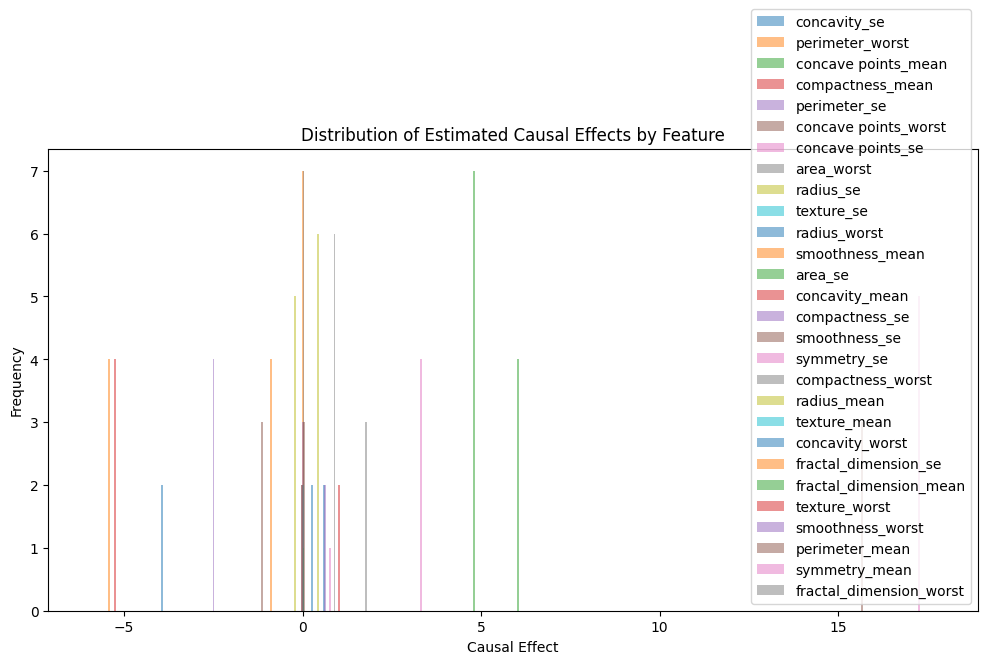

In [ ]:
def plot_causal_effects(causal_results):
    plt.figure(figsize=(12, 6))
    for feature in causal_results['feature'].unique():
        feature_data = causal_results[causal_results['feature'] == feature]
        plt.hist(feature_data['causal_effect'], bins=20, alpha=0.5, label=feature)

    plt.title('Distribution of Estimated Causal Effects by Feature')
    plt.xlabel('Causal Effect')
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()

plot_causal_effects(simulation_results)


**After Visualising this plot and the summary table we understand that :**

The features: concave_points_se ,smoothness_se ,fractal_dimension_mean ,concave_points_mean ,symmetry_se ,fractal_dimension_worst ,compactness_worst ,symmetry_mean ,concavity_mean ,smoothness_worst ,concavity_worst ,radius_se and radius_worst have an effective positive causal effect.
Furthermore ,the features:fractal_dimension_se ,compactness_mean ,concavity_se ,radius_mean ,smoothness_mean and concave points_worst have an effective negative causal effect.

The features:area_worst ,texture_mean ,perimeter_mean ,texture_worst ,perimeter_se ,texture_se ,perimeter_worst and area_se have a negligible impact on the diagnosis and hence can be ommitted when dimensionality reduction or feature reduction needs to be done without loss of information and major changes in the accuracy of prediction using any model.(GNN in our case)

This effect is for predicting whether the breast cancer is malignant or not.


**Monte Carlo Simulation for Prediction Uncertainty (Optional)**
# --------------------------------------------------------------------
This optional step involves running a Monte Carlo simulation for prediction uncertainty. We generate multiple predictions to assess the variability in predictions.This is an additional step we did to ensure robustness of the prediction if the model.

In [ ]:
def monte_carlo_prediction_uncertainty(num_simulations=100):
    model.eval()  # Set the model to evaluation mode
    predictions = []

    for _ in range(num_simulations):
        with torch.no_grad():
            # Forward pass through the model for all nodes in the data
            out = model(test_data.x, test_data.edge_index)
            predictions.append(out.cpu().numpy())  # Store raw predictions for uncertainty calculation

    # Convert predictions to a numpy array for easier manipulation
    predictions = np.array(predictions)
    mean_predictions = np.mean(predictions, axis=0)  # Mean prediction over all simulations
    uncertainty = np.std(predictions, axis=0)  # Standard deviation as a measure of uncertainty

    return mean_predictions, uncertainty


In [ ]:
# The simulation is run to calculate the mean predictions and their uncertainty across multiple simulations.
mean_preds, uncertainties = monte_carlo_prediction_uncertainty()
print("Mean Predictions:", mean_preds)
print("Prediction Uncertainties:", uncertainties)

Mean Predictions: [[-4.1505713e+00 -1.5880905e-02]
 [-1.0903578e+01 -1.8358083e-05]
 [-1.4707150e+01 -3.5762784e-07]
 [-1.6343740e+01 -1.1920928e-07]
 [-1.7126101e+01  0.0000000e+00]
 [-1.7956429e+01  0.0000000e+00]
 [-1.8934450e+01  0.0000000e+00]
 [-1.9670042e+01  0.0000000e+00]
 [-2.0177513e+01  0.0000000e+00]
 [-2.0539675e+01  0.0000000e+00]
 [-2.0787203e+01  0.0000000e+00]
 [-2.1025389e+01  0.0000000e+00]
 [-2.1187895e+01  0.0000000e+00]
 [-2.1297451e+01  0.0000000e+00]
 [-2.1369631e+01  0.0000000e+00]
 [-2.1403191e+01  0.0000000e+00]
 [-2.1407625e+01  0.0000000e+00]
 [-2.1389137e+01  0.0000000e+00]
 [-2.1355335e+01  0.0000000e+00]
 [-2.1346796e+01  0.0000000e+00]
 [-2.1339485e+01  0.0000000e+00]
 [-2.1322399e+01  0.0000000e+00]
 [-2.1340574e+01  0.0000000e+00]
 [-2.1346813e+01  0.0000000e+00]
 [-2.1340691e+01  0.0000000e+00]
 [-2.1322268e+01  0.0000000e+00]
 [-2.1296276e+01  0.0000000e+00]
 [-2.1262230e+01  0.0000000e+00]
 [-2.1222990e+01  0.0000000e+00]
 [-2.1213007e+01  0.00000

As u can see the prediction uncertanities for the test data are consistently 0. This ensures that the model is robust in its predictions.

Creating the reduced dataset and retraining the model on reduced dataset
#----------------------------------------------

Now we reduce the dataset to contain only the important features

In [ ]:
import pandas as pd

# Load the dataset
file_path = '/content/ADAdata.csv'  # Replace with your actual file path
data = pd.read_csv(file_path)

# Correct feature lists to match dataset columns
features_positive_effect = [
    'concave points_se', 'smoothness_se', 'fractal_dimension_mean', 'concave points_mean',
    'symmetry_se', 'fractal_dimension_worst', 'compactness_worst', 'symmetry_mean',
    'concavity_mean', 'smoothness_worst', 'concavity_worst', 'radius_se', 'radius_worst'
]

features_negative_effect = [
    'fractal_dimension_se', 'compactness_mean', 'concavity_se', 'radius_mean',
    'smoothness_mean', 'concave points_worst'
]

target_label = ['diagnosis']

# Combine the features into one list
selected_features = features_positive_effect + features_negative_effect + target_label

# Verify that all selected features exist in the dataset
selected_features = [feature for feature in selected_features if feature in data.columns]

# Filter the dataset to include only the selected features
reduced_data = data[selected_features]

# Save the reduced dataset to a new file (optional)
output_file_path = 'ADAdata_reduced.csv'
reduced_data.to_csv(output_file_path, index=False)

print(f"Reduced dataset saved to {output_file_path}")


Reduced dataset saved to ADAdata_reduced.csv


Now train the new model with the new reduced dataset.Lets observe how this affects the performance of the model.

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
dataset = pd.read_csv('/content/ADAdata_reduced.csv')
# Extract features and labels
labels = dataset['diagnosis'].map({'M': 1, 'B': 0})
features = dataset.drop(columns=['diagnosis']).values

# Now you have the full dataset with 'diagnosis' encoded as 1 and 0
#Converting it to the format required for training the model
features = torch.tensor(features, dtype=torch.float).to(device)
labels = torch.tensor(labels, dtype=torch.long).to(device)

# Handle NaN or Inf values
if torch.any(torch.isnan(features)) or torch.any(torch.isinf(features)):
    print("NaN or Inf detected in the input data!")

    # Option 1: Replace NaNs with the mean of each column
    features = features.cpu().numpy()
    nan_mask = np.isnan(features)

    for col in range(features.shape[1]):
        features[nan_mask[:, col], col] = np.nanmean(features[:, col])

    # Convert back to tensor
    features = torch.tensor(features, dtype=torch.float).to(device)

# Ensure labels are not empty after cleaning
if features.size(0) == 0 or labels.size(0) == 0:
    raise ValueError("No valid data left after cleaning!")

X_train, X_test, y_train, y_test = train_test_split(features.cpu().numpy(), labels.cpu().numpy(), test_size=0.2, random_state=42)

# Convert the splits back to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float).to(device)
y_train = torch.tensor(y_train, dtype=torch.long).to(device)
X_test = torch.tensor(X_test, dtype=torch.float).to(device)
y_test = torch.tensor(y_test, dtype=torch.long).to(device)

num_epochs = 200
for epoch in range(num_epochs):
    loss = train()
    if epoch % 20 == 0:
        train_acc = test(train_data)
        test_acc = test(test_data)
        print(f'Epoch: {epoch}, Loss: {loss:.4f}, Train Accuracy: {train_acc:.4f}, Test Accuracy: {test_acc:.4f}')

# Step 8: Fine-tune the test graph after training
fine_tune_test_graph()

# Re-evaluate the test accuracy after fine-tuning
test_acc = test(test_data)
print(f'Final Test Accuracy after fine-tuning: {test_acc:.4f}')



Epoch: 0, Loss: 0.6656, Train Accuracy: 0.6286, Test Accuracy: 0.6228
Epoch: 20, Loss: 0.6602, Train Accuracy: 0.6286, Test Accuracy: 0.6228
Epoch: 40, Loss: 0.6586, Train Accuracy: 0.6286, Test Accuracy: 0.6228
Epoch: 60, Loss: 0.6595, Train Accuracy: 0.6286, Test Accuracy: 0.6228
Epoch: 80, Loss: 0.6596, Train Accuracy: 0.6286, Test Accuracy: 0.6228
Epoch: 100, Loss: 0.6596, Train Accuracy: 0.6286, Test Accuracy: 0.6228
Epoch: 120, Loss: 0.6592, Train Accuracy: 0.6286, Test Accuracy: 0.6228
Epoch: 140, Loss: 0.6589, Train Accuracy: 0.6286, Test Accuracy: 0.6228
Epoch: 160, Loss: 0.6595, Train Accuracy: 0.6286, Test Accuracy: 0.6228
Epoch: 180, Loss: 0.6587, Train Accuracy: 0.6286, Test Accuracy: 0.6228
Fine-tuning completed.
Final Test Accuracy after fine-tuning: 0.6228


From the performance of the model it can be deduced that our reduced dataset doesnt compromise on the performance of the model and the chosen features are truly relevant.